In [1]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from xavier.modeling import DementiaMRIClassification, fit, accuracy, evaluate
from xavier.explain import Explainer
import shap

## Data Preparation

In [2]:
data_dir = './data/mri_images/train/'

image_transforms = transforms.Compose([
    transforms.CenterCrop(175),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(data_dir, transform=image_transforms)
classes = dataset.class_to_idx

In [3]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

batch_size = 128
val_size = 1000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 4121
Length of Validation Data : 1000


## Training

In [6]:
device = 'cpu'
conv_layers=[(32, 3), (64, 3), (128, 3), (256, 3), (512, 3), (1024, 3), (2048, 3)]
linear_layers=[1024, 512, 256, 64]
image_size = (175, 175)

model = DementiaMRIClassification(n_classes=4, image_size=image_size, conv_layers=conv_layers, linear_layers=linear_layers).to(device)
print(model)

DementiaMRIClassification(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): C

In [7]:
# Model training
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001 # fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func, device=device)

## Evaluation

In [4]:
model_path = "./models/conv.pt"

model = DementiaMRIClassification(n_classes=4, transforms=image_transforms)
model.load_state_dict(torch.load(model_path))

RuntimeError: Error(s) in loading state_dict for DementiaMRIClassification:
	Missing key(s) in state_dict: "cnn.0.weight", "cnn.0.bias", "cnn.2.weight", "cnn.2.bias", "cnn.5.weight", "cnn.5.bias", "cnn.7.weight", "cnn.7.bias", "cnn.10.weight", "cnn.10.bias", "cnn.12.weight", "cnn.12.bias", "dnn.0.weight", "dnn.0.bias", "dnn.2.weight", "dnn.2.bias", "dnn.4.weight", "dnn.4.bias". 
	Unexpected key(s) in state_dict: "network.0.weight", "network.0.bias", "network.2.weight", "network.2.bias", "network.5.weight", "network.5.bias", "network.7.weight", "network.7.bias", "network.10.weight", "network.10.bias", "network.12.weight", "network.12.bias", "network.16.weight", "network.16.bias", "network.18.weight", "network.18.bias", "network.20.weight", "network.20.bias". 

In [6]:
# evaluate(model, val_dl)

## Explanation & Evaluation

In [7]:
# test_image_path = "./data/mri_images/test/ModerateDemented/27.jpg"
# image = Image.open(test_image_path).convert('RGB')
# imshow(image)

# layers, feature_maps = model._single_image_feature_map(image, True)
# model.plot_feature_maps(layers, feature_maps)

In [8]:
test_data_dir = './data/mri_images/test/'
test_dataset = datasets.ImageFolder(test_data_dir, transform=image_transforms)
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=True)

batch = next(iter(test_dl))
images, labels = batch

images = images.view(-1, 3, 175, 175)
test_images = images[:10]

background shape: torch.Size([1, 3, 175, 175]), test_images shape: torch.Size([127, 3, 175, 175])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(10, 175, 175, 3) (10, 175, 175, 3)


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


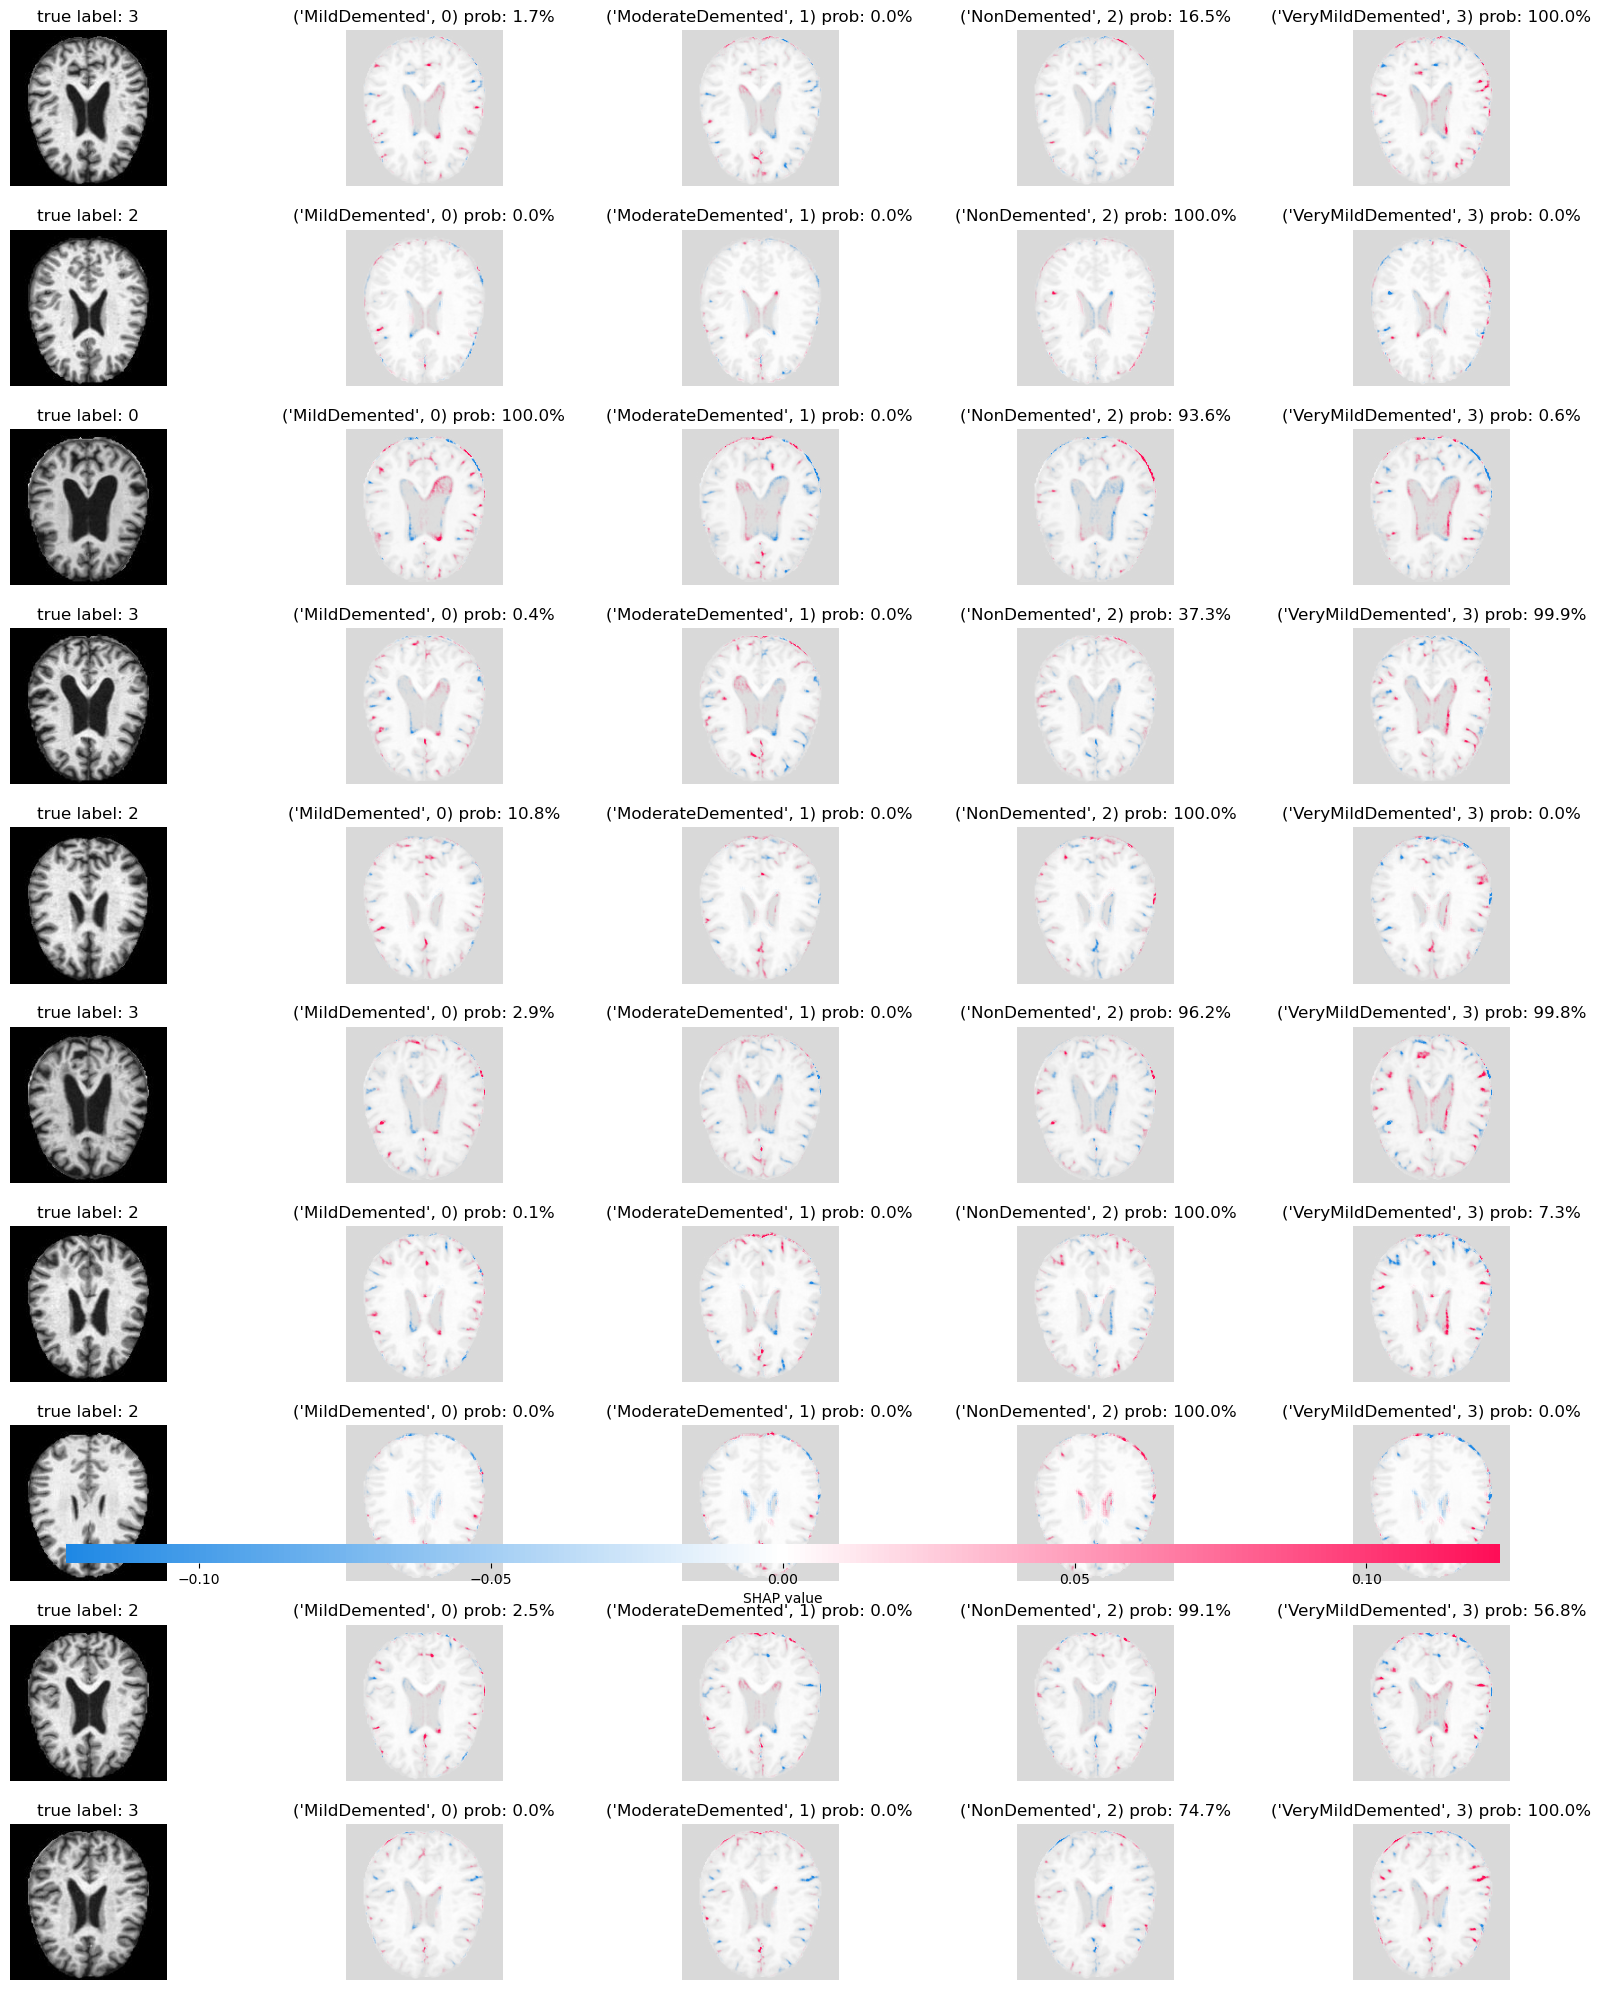

In [11]:
class_names = list(classes.items())

explainer = Explainer(model, test_dl, class_names)
explainer.plot_shap_values(test_images)